# Homework 3 - Pedestrian Detection using Histogram of Oriented Gradients

## Topics:
- Data Preparation
- Feature extraction: Histogram of Oriented Gradients
- Classification: Support Vector Machine
- Object Detection: Sliding Window + Non Maximum Supression


## Sources & Material
- Datasets: 
    - https://www.cis.upenn.edu/~jshi/ped_html/
    - http://pascal.inrialpes.fr/data/human/
- Dataset preprocessed: https://github.com/RashadGarayev/PersonDetection
- Paper: Dalal and Triggs, “Histograms of oriented gradients for human detection,” CVPR05
    - https://hal.inria.fr/inria-00548512/document/
    
## Further Reading
- https://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/
 

# 1. Import Libraries
- OpenCV
- scikit-image
- scikit-learn

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import os
from sklearn import svm
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, f1_score, recall_score, precision_score

import utils

# 2. Prepare Data 

1. Create a dataset by loading all images
    - positive samples that contain pedestrians
    - negative samples that contain background objects
2. Split data into training and test data
    - split positive examples 
    - split negative examples

In [4]:
# Read Image files from local file system
positive_files = utils.ls("dataset/positive/")
negative_files = utils.ls("dataset/negative/")

split_pos = int(0.7*len(positive_files))
split_neg = int(0.7*len(negative_files))

train_positive_files, test_positive_files =  positive_files[:split_pos],positive_files[split_pos:]
train_negative_files, test_negative_files =  negative_files[:split_neg],negative_files[split_neg:]

# TODO: 
# Read the images and store them in their corresponding lists

train_positive = [cv.imread(img)[:, :, ::-1] for img in train_positive_files]
train_negative = [cv.imread(img)[:, :, ::-1] for img in train_negative_files]

test_positive = [cv.imread(img)[:, :, ::-1] for img in test_positive_files]
test_negative = [cv.imread(img)[:, :, ::-1] for img in test_negative_files]

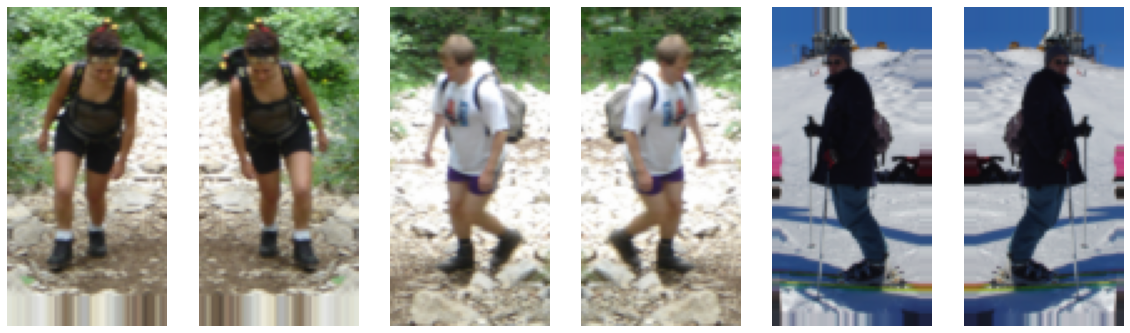

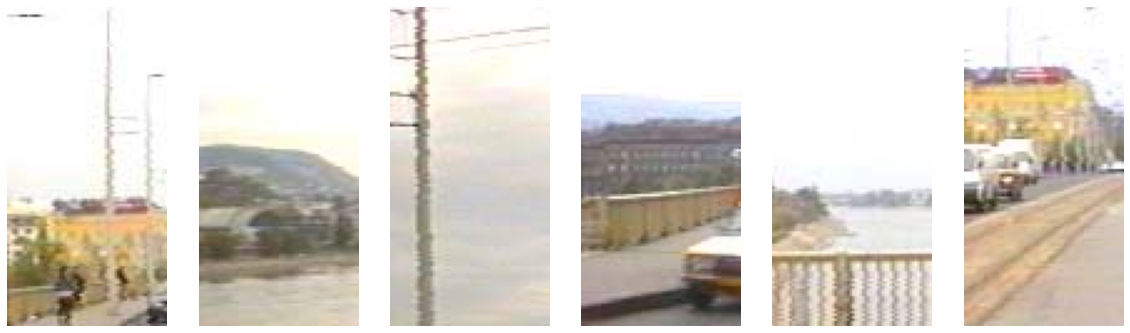

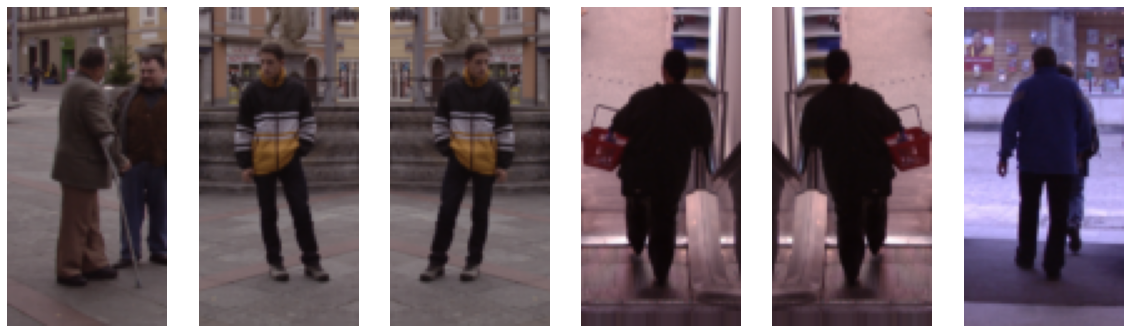

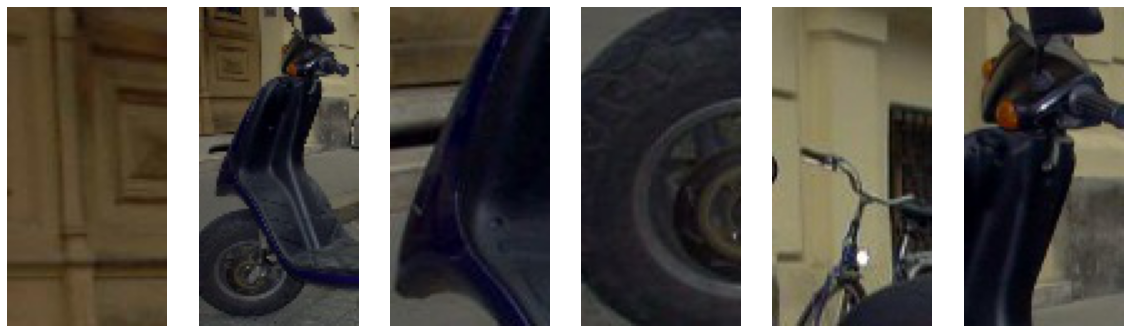

In [5]:
# You can visualize the examples:
utils.showImages(train_positive[:6])
utils.showImages(train_negative[:6])

utils.showImages(test_positive[:6])
utils.showImages(test_negative[:6])

# 3. Feature Extraction

1. Apply Histogram of Oriented Gradients on all data
2. Create Training Labels

## HOG -  Example

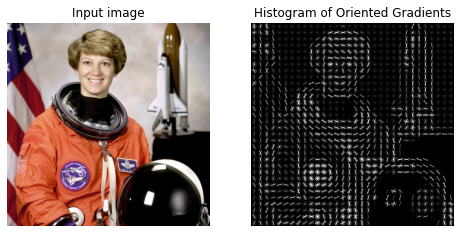

In [6]:
from skimage import data


img = data.astronaut()


fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(3, 3), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## 3.1 Compute HOG for each Image

In [7]:
def feature_extraction(img, ppc = 8, cpb = 2):
    """
    img: A coloured image
    ppc: Pixels per cell
    cpb: Cells per block
    
    return: HOG feature vector 
    The 
    """
    # TODO: compute HOG feature vector
    # - try different parameters 
    # - the output should be a one-dimensional array

    fd = hog(img, orientations=8, pixels_per_cell=(ppc, ppc),
                    cells_per_block=(cpb, cpb), channel_axis=-1)
    return fd


# Training Samples
train_positive_hog = np.array([feature_extraction(img) for img in train_positive])
train_negative_hog = np.array([feature_extraction(img) for img in train_negative])

# Testing Samples
test_positive_hog = np.array([feature_extraction(img) for img in test_positive])
test_negative_hog = np.array([feature_extraction(img) for img in test_negative])

# 3.2 Labels

In [8]:
# Combine positive and negative samples into data matrices 
X = np.concatenate((train_positive_hog,train_negative_hog))
X_test = np.concatenate((test_positive_hog,test_negative_hog))

# Create array of corresponding labels
Y = np.zeros(len(X))
Y[:len(train_positive_hog)] = 0
Y[len(train_positive_hog):] = 1

Y_test = np.zeros(len(X_test))
Y_test[:len(test_positive_hog)] = 0
Y_test[len(test_positive_hog):] = 1

# 4. Classifier

1. Initialize Model
2. Train Model
3. Evaluate Model

# 4.1 & 4.2

In [9]:
svc = svm.LinearSVC(C=0.6,max_iter=10000)
svc.fit(X,Y)

LinearSVC(C=0.6, max_iter=10000)

# 4.3 Evaluate Model

In [10]:
Y_pred = svc.predict(X_test)

# Confusion Matrix
$$C = \left( \begin{matrix} \text{True Negatives} & \text{False Positives} \\ \text{False Negatives} & \text{True Positives} \end{matrix} \right) $$

In [11]:
confusion_matrix(Y_test,Y_pred)

array([[ 653,   72],
       [  65, 1171]])

In [12]:
print("AP:", average_precision_score(Y_test,Y_pred))
print("Accuracy:", accuracy_score(Y_test,Y_pred))
print("Recall:", recall_score(Y_test,Y_pred))
print("Precision:", precision_score(Y_test,Y_pred))
print("F1:", f1_score(Y_test,Y_pred))

AP: 0.9256791654776148
Accuracy: 0.930137684854666
Recall: 0.9474110032362459
Precision: 0.9420756234915527
F1: 0.9447357805566761


# 5. How to use the classifier on real images

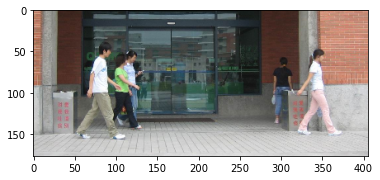

In [13]:
img = cv.imread("Images/FudanPed00036.png")[:,:,::-1]
scale = 0.4
img = cv.resize(img, (int(scale*img.shape[1]),int(scale*img.shape[0]))) 
plt.imshow(img)
plt.show()

In [14]:
height, width = 128, 64
import utils
def detect(img, svc, step = 10, height = 128, width = 64):
    """
    img: any image
    svc: Support Vector Classifier
    step: Step size of window operation
    
    return:
        result: a matrix with the predicted labels result[i,j] != 0 means that at the given window a pedestrian was found
        bounding_boxes [N, 4]: A matrix of bounding boxes corresponding to found pedestrians. 
        bounding_boxes[i,0:2] describe the upper left corner and bounding_boxes[i,2:4] describe the bottom right corner. 
    """
    # Iterate over image and apply classifier
    result = np.zeros(img.shape[:2])-1
    for i in range(0,img.shape[0]-height, step):
        for j in range(0,img.shape[1]-width, step):
            result[i,j] = svc.predict(feature_extraction(img[i:i+height,j:j+width]).reshape(1, -1))[0]
    
    y,x = np.nonzero(result==0)
    bounding_boxes = np.stack([x,y,x+width,y+height],1)
    return result, bounding_boxes

In [15]:
def draw_bbs(img, bounding_boxes, title=None):
    fig, axs = plt.subplots(1, 4, figsize=(32, 7))
    fig.suptitle(title, fontsize=32, fontweight='bold')
    for idx, thresh in enumerate([0.1, 0.25, 0.4, 0.55]):
        bounding_boxes_filtered = utils.non_max_suppression_fast(bounding_boxes, thresh)
        res = img.copy()      
        for i in range(len(bounding_boxes_filtered)):
            x_1, y_1 = bounding_boxes_filtered[i,0],bounding_boxes_filtered[i,1]
            x_2, y_2 = bounding_boxes_filtered[i,2],bounding_boxes_filtered[i,3]
            
            res = cv.rectangle(res.astype(np.float32),(x_1, y_1),(x_2, y_2),(0,255,0),3).astype(np.uint8)
        axs[idx].set_title(f'Thresh: {thresh}', fontsize=24, fontweight='bold')
        axs[idx].imshow(res)

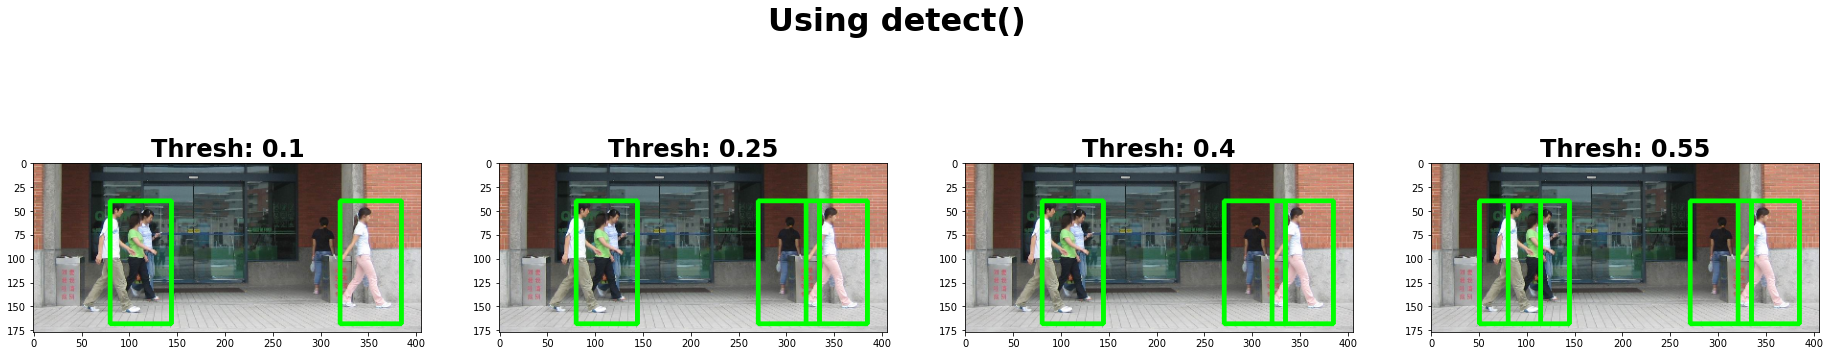

In [16]:
_, bounding_boxes = detect(img, svc)
draw_bbs(img, bounding_boxes, 'Using detect()')

# 6 Deploy Model on Multiple Scales

The model only detects pedestrians in a specific resolution (64x128).
Extend the application of the model to any resolution.

TODO
- Scale the images 
- Detect people
- apply nonmaxima supression over multiple scales

In [54]:
scales_1 = [0.3, 0.5, 0.01]
scales_2 = [0.5, 1.0 + 1e-10, 0.1]

def multi_scale_detect(img, svc, step = 16, height = 128, width = 64):

    def get_boxes(args):
        boxes = []
        for scale in np.arange(*args):
            scaled_shape = tuple(np.uint16(np.array(img.shape[:2][::-1]) * scale))
            scaled_img = cv.resize(img, scaled_shape) 
            _, new_boxes = detect(scaled_img, svc, step=step, height=height, width=width)

            if new_boxes.size != 0:
                new_boxes = utils.non_max_suppression_fast(new_boxes, 0.4)
                new_boxes = new_boxes // scale
                boxes.append(new_boxes)
        return boxes
    
    boxes = get_boxes(scales_1)
    if len(boxes) == 0:
        step = 15
        boxes = get_boxes(scales_2)
    if len(boxes) != 0:
        boxes = np.concatenate(boxes, 0)
    else:
        boxes = np.array(boxes)
    return boxes


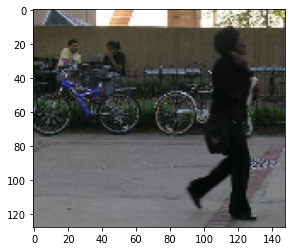

In [23]:
img = cv.imread("Images/PennPed00064.png")[:,:,::-1]
scale = 0.4
img = cv.resize(img, (int(scale*img.shape[1]),int(scale*img.shape[0]))) 
plt.imshow(img)
plt.show()

In [53]:
[-1] * 4

[-1, -1, -1, -1]

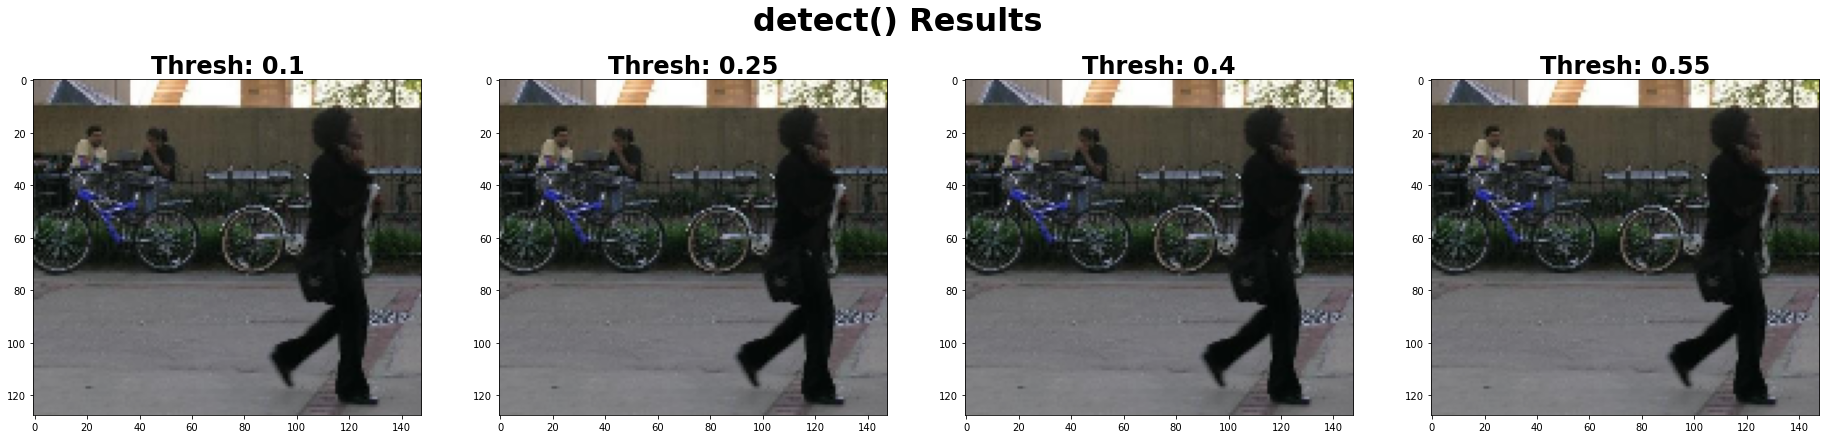

In [24]:
result, bounding_boxes = detect(img, svc)
draw_bbs(img, bounding_boxes, 'detect() Results')

In [55]:
img = cv.imread("Images/PennPed00064.png")[:,:,::-1]
bounding_boxes = multi_scale_detect(img, svc)
draw_bbs(img, bounding_boxes, 'multi_scale_detect() results')


ValueError: cannot reshape array of size 4 into shape (1,1,1,1)

PennPed00071.png
PennPed00040.png
PennPed00091.png
PennPed00039.png
FudanPed00007.png


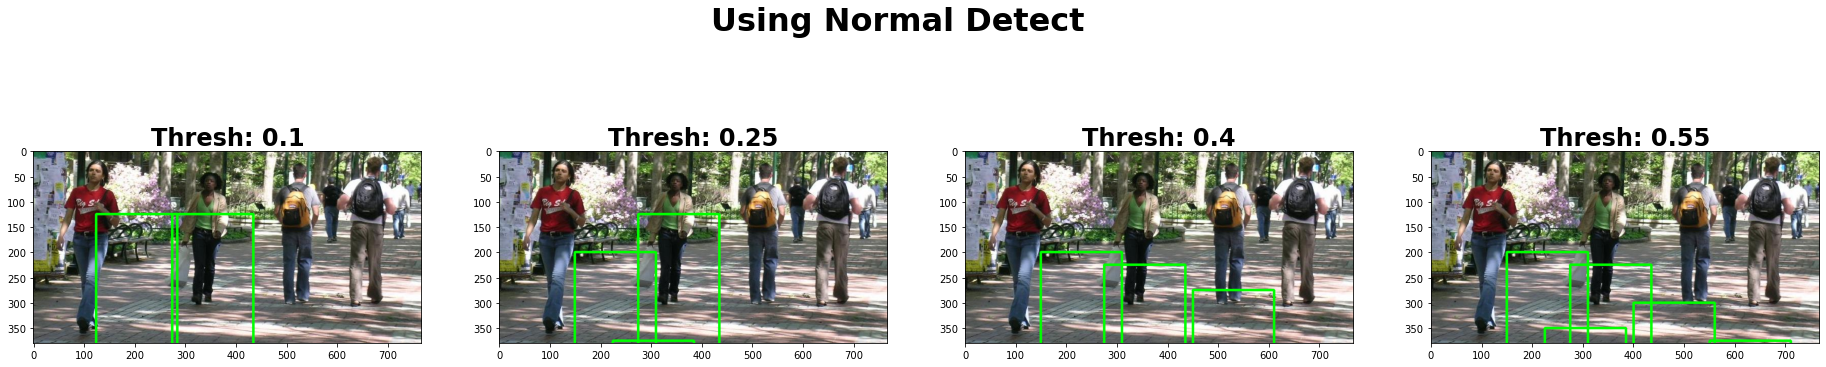

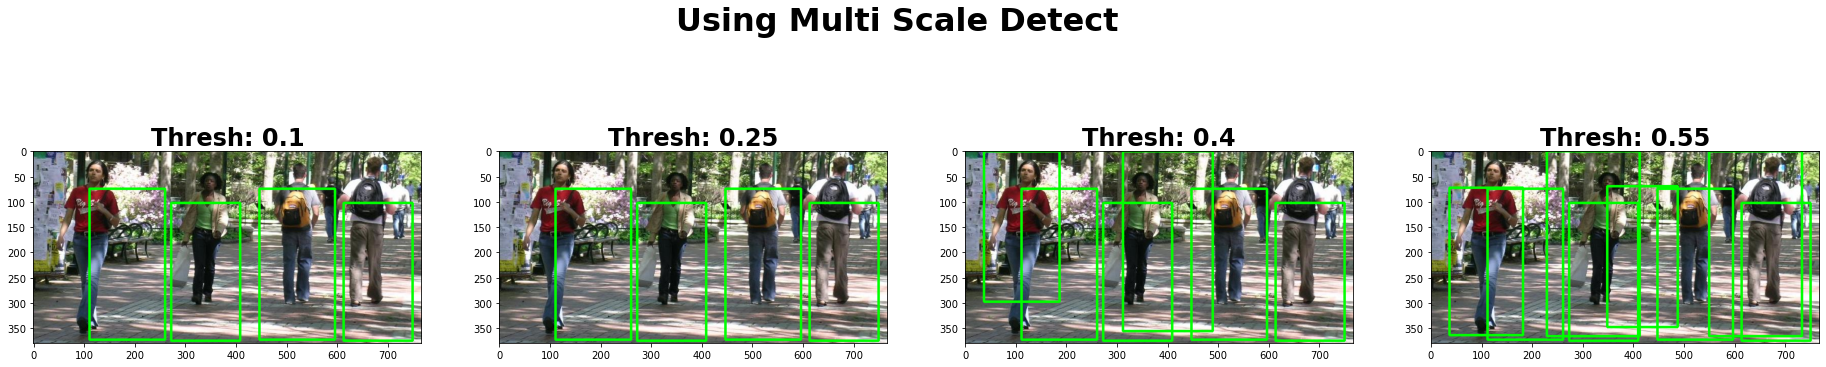

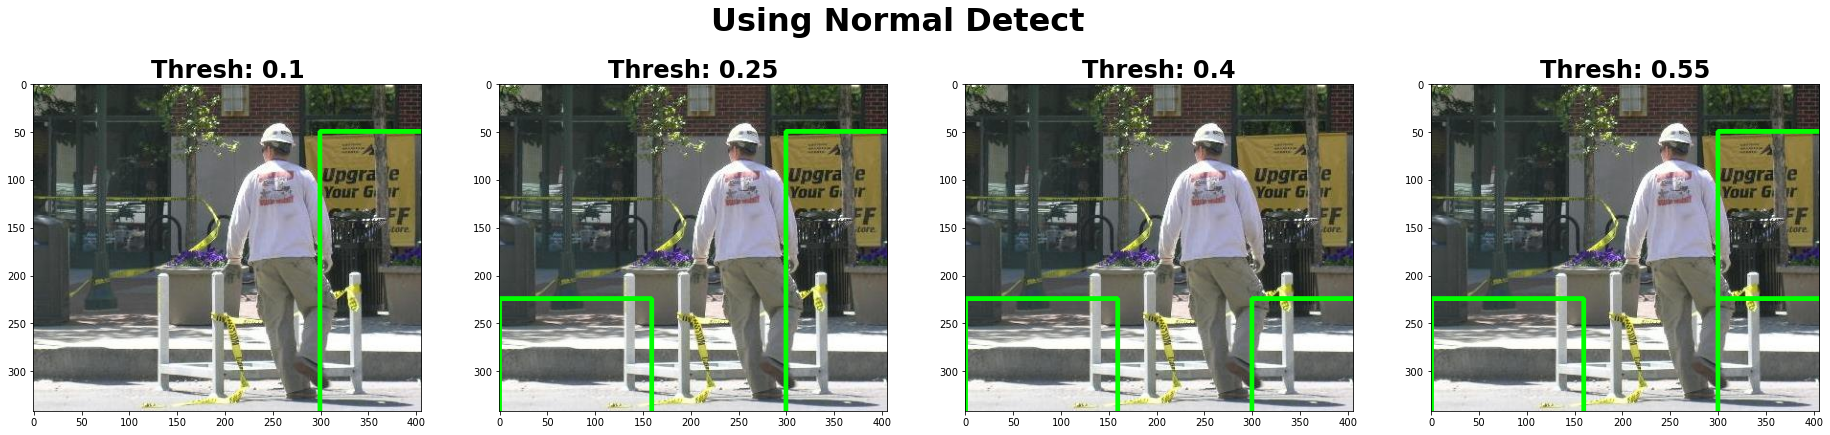

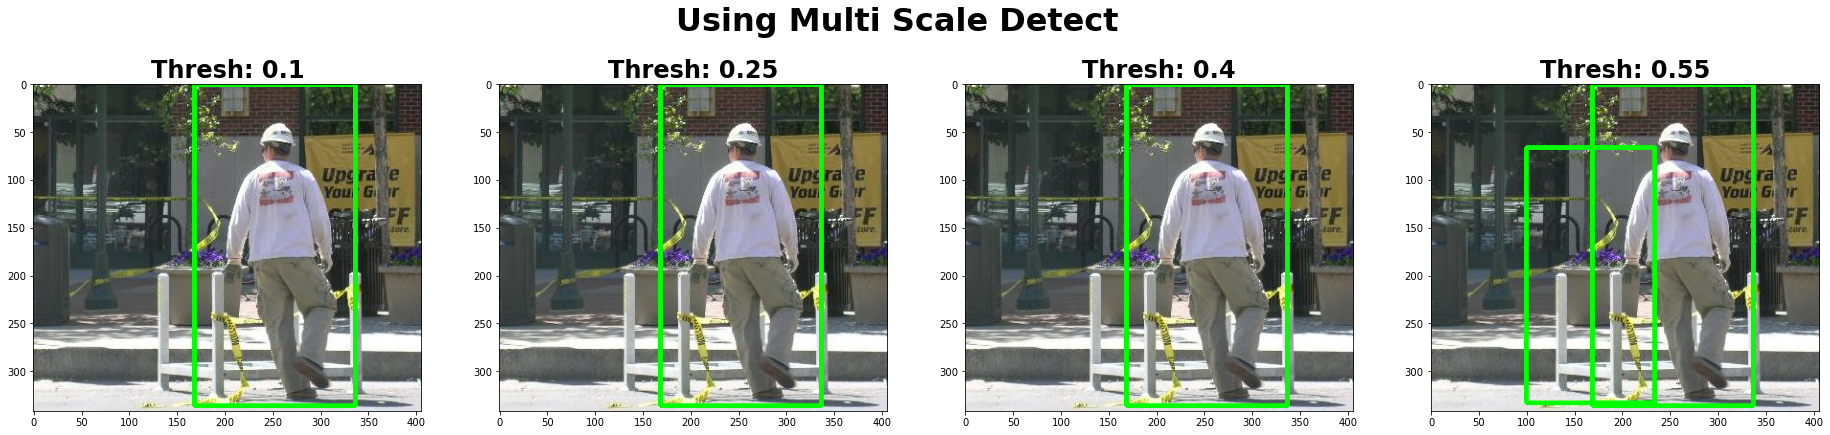

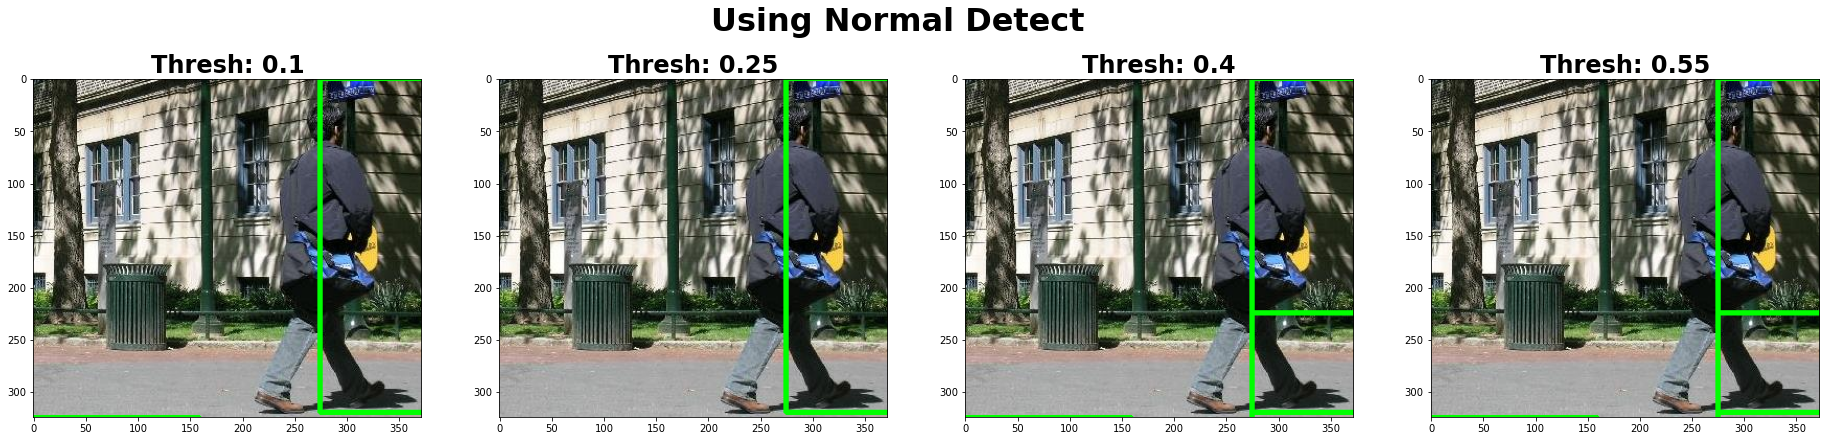

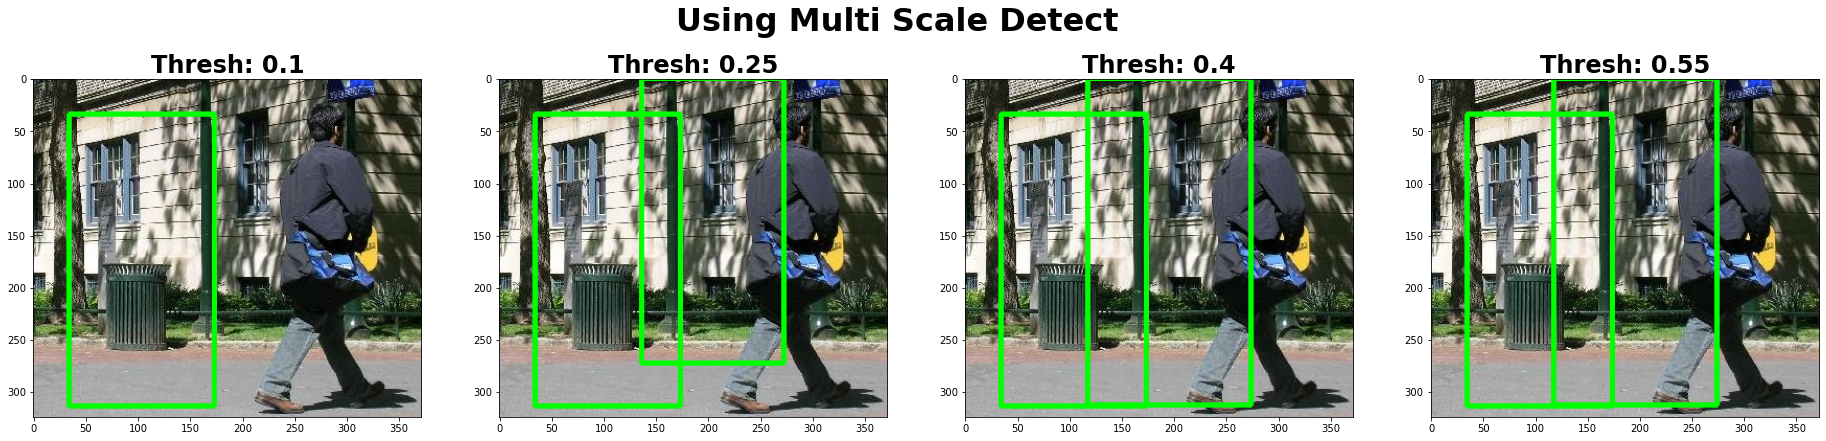

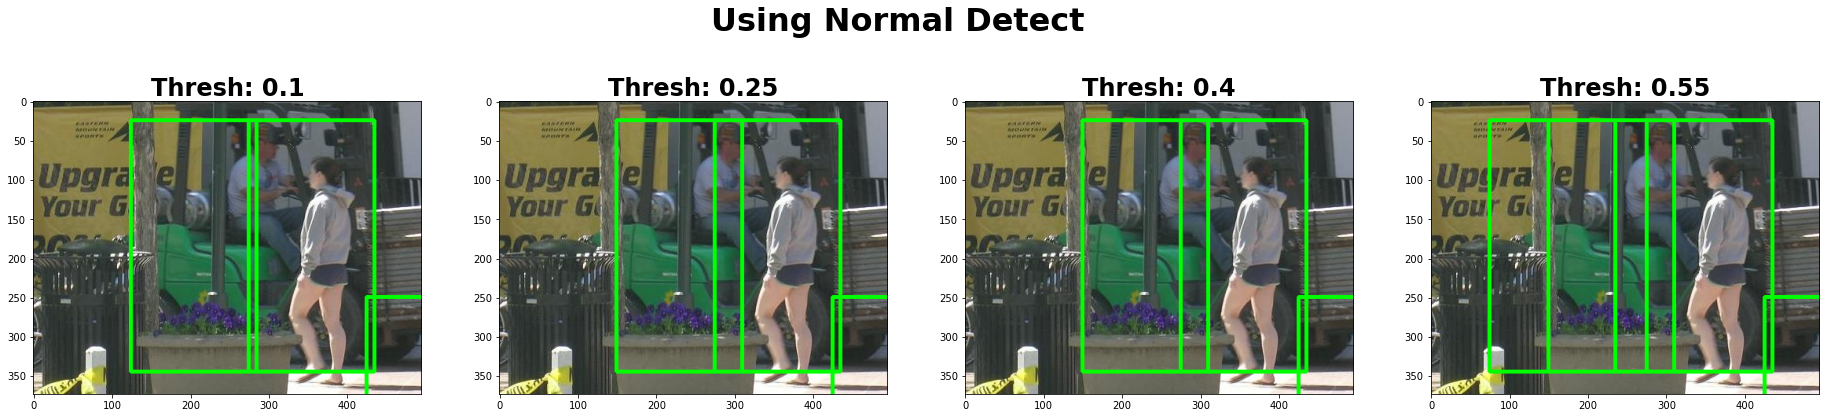

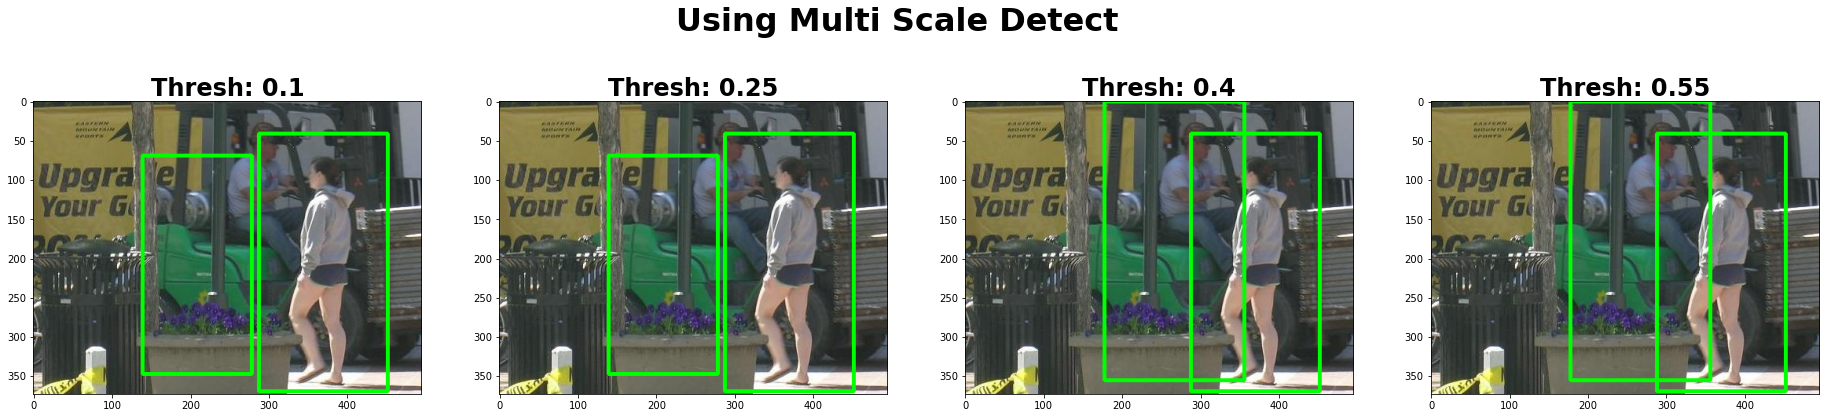

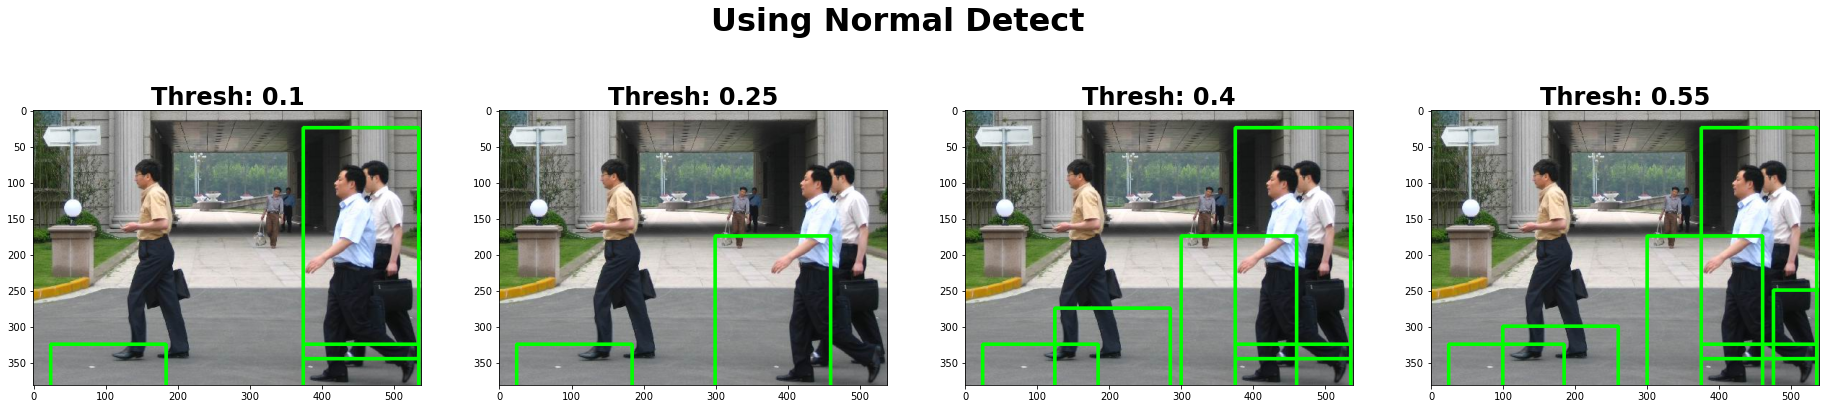

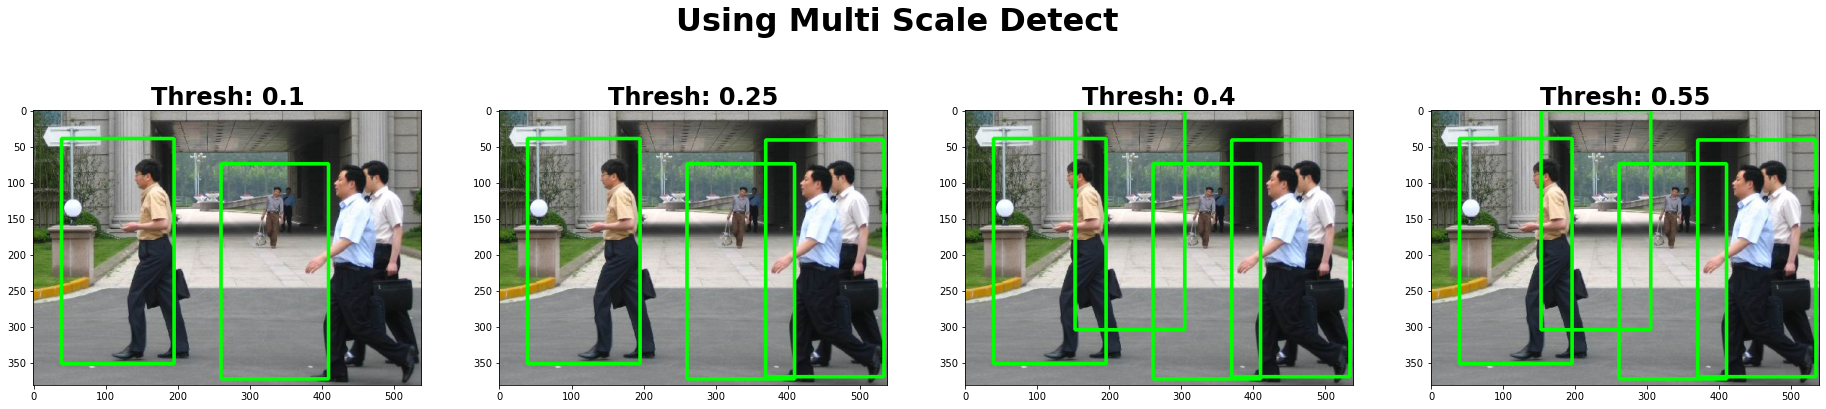

In [21]:
from os import listdir
from random import choice

for i in range(5):
    img_name = choice(listdir('Images'))
    img = cv.imread(f'Images/{img_name}')[:, :, ::-1]
    
    # Normal detect function with image scaled down.
    _, bounding_boxes = detect(img , svc)
    draw_bbs(img, bounding_boxes // 0.4, 'Using Normal Detect')

    # Multi-scale detect function.
    bounding_boxes = multi_scale_detect(img, svc)
    draw_bbs(img, bounding_boxes, 'Using Multi Scale Detect')
    
    print(img_name)
    